# Plots of differences at initialization times

## Setup

In [1]:
# Import statements

import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from typing import List
from xskillscore.core.resampling import resample_iterations_idx
from dask.diagnostics import ProgressBar #type: ignore
import cartopy.feature as cfeature
import metpy.calc as mpcalc


# Set default style to dark background because I like it better
plt.style.use("dark_background")
plt.rcParams["hatch.linewidth"] = 0.3


In [2]:
# Define useful functions
def get_wofs_all(init: int) -> xr.Dataset:
    """Read in WoFS output based on initialization time."""
    file_pattern = f"/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc"
    loaded = xr.open_mfdataset(
        file_pattern, combine="nested", concat_dim="time", chunks="auto"
    )

    if init < 6:
        start_time = f"2021-09-02 {init:02d}:00:00"
        end_time = f"2021-09-02 {init + 6:02d}:00:00"
    elif init == 17:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-01 {init + 6:02d}:00:00"
    else:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-02 {init - 24 + 6:02d}:00:00"


    loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
    return loaded


def smooth(da: xr.DataArray, sigma: int = 3, axes: tuple = (1, 2)) -> xr.DataArray:
    """Apply Gaussian smoothing to the DataArray."""
    smoothed_da = da.copy()
    smoothed_da.values = gaussian_filter(da.values, sigma=sigma, axes=axes)
    smoothed_da = smoothed_da.assign_attrs(da.attrs)
    return smoothed_da


def get_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Return a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [w[varname].sel(time=slice(start_time, end_time)) for w in wofs_list],
        dim=init_dim,
    ).chunk({"init": -1})


In [3]:
# Load in the 17Z initalizations
wofs = get_wofs_all(17)

In [4]:
# Define variables and parameters
lat = wofs.xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs.xlon.isel(time=0).squeeze().drop_vars("time")

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs.attrs["CEN_LON"],
    central_latitude=wofs.attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # WoFS projection

In [5]:
# Get the wet and dry ensemble members
wet_ne = [4, 6, 7, 10]
dry_ne = [0, 5, 12, 16]


## Convective ingredients

### PW

In [10]:
# Grab PW at initialization time
pw = wofs.pw.isel(time=0)
pw_wet = xr.concat([pw.isel(ne=n) for n in wet_ne], dim="ne")
pw_dry = xr.concat([pw.isel(ne=n) for n in dry_ne], dim="ne")

In [11]:
# Chunk lat and lon of pw
pw_chunked = pw.squeeze().chunk({"lat": 25, "lon": 25})

# Resample and compute means
set1 = resample_iterations_idx(
    pw_chunked,
    1000,
    dim="ne",
    replace=False,
    dim_max=4,
).mean(dim="ne")

set2 = resample_iterations_idx(
    pw_chunked,
    1000,
    dim="ne",
    replace=False,
    dim_max=4,
).mean(dim="ne")

# Compute the difference and quantiles
with ProgressBar():
    result = (set1 - set2).quantile([0.025, 0.975], dim="iteration").compute()

[########################################] | 100% Completed | 45.69 ss


In [13]:
# Get difference between wet and dry ensemble members
diff = (pw_wet.mean(dim="ne") - pw_dry.mean(dim="ne")).compute()

mask = (diff < result.sel(quantile=0.025).squeeze()) | (  # type: ignore
    diff > result.sel(quantile=0.975).squeeze()  # type: ignore
)


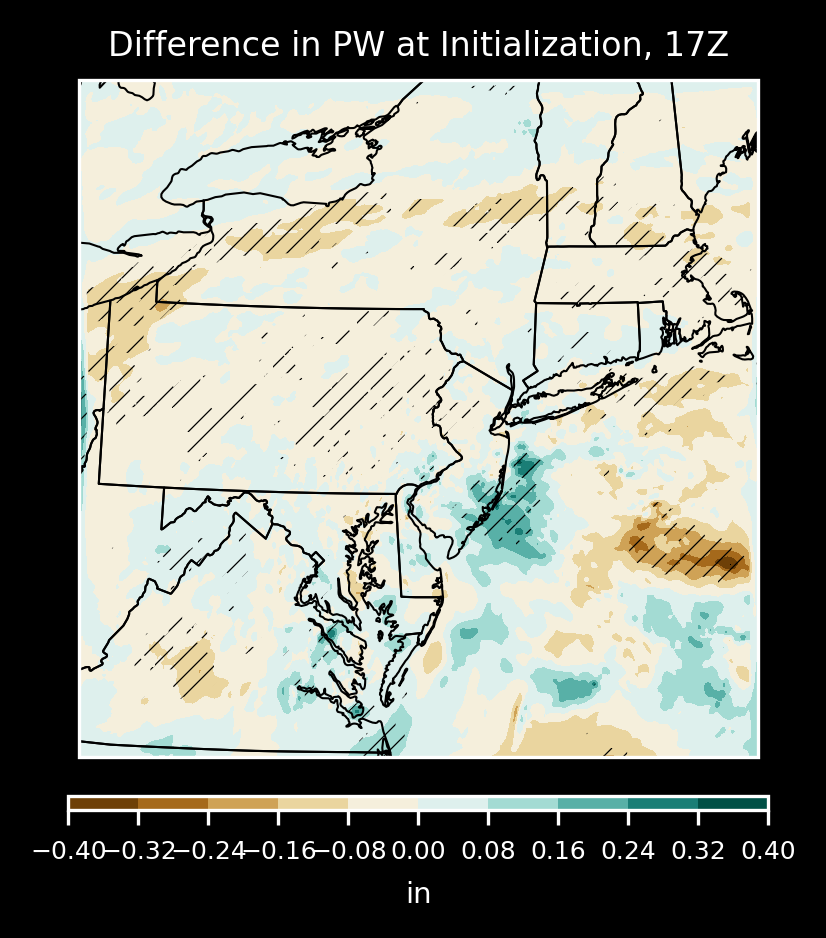

In [14]:
levels = np.arange(-0.4, 0.41, 0.08)

# Make empty figure with subplots
fig, ax = plt.subplots(
    1,
    1,
    subplot_kw=dict(projection=proj),
    dpi=300,
    layout="constrained",
    figsize=(3, 3),
)

# Plot difference
c = ax.contourf(
    lon,
    lat,
    diff,
    levels=levels,
    transform=ccrs.PlateCarree(),
    cmap="BrBG",
)

# Hatch over statistically significant areas
m = ax.contourf(
    lon,
    lat,
    mask,
    transform=ccrs.PlateCarree(),
    levels=[0, 0.5, 1],
    hatches=["", "/////"],
    colors="none",
)

# Add states
c.axes.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="black")  # type: ignore

# Add colorbar to figure
cb = fig.colorbar(
    c,
    ax=ax,
    shrink=0.8,
    aspect=50,
    orientation="horizontal",
)
cb.ax.tick_params(labelsize=6)
cb.set_label("in", fontsize=7)
cb.set_ticks(levels)

# Add title
plt.title("Difference in PW at Initialization, 17Z", fontsize=8)

plt.show()


In [96]:
wofs.theta_e

<xarray.DataArray 'theta_e' (time: 73, ne: 18, lat: 300, lon: 300)> Size: 946MB
dask.array<concatenate, shape=(73, 18, 300, 300), dtype=float64, chunksize=(1, 18, 300, 300), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 584B 2021-09-01 17:00:00 ... 2021-09-01 23:00:00
Dimensions without coordinates: ne, lat, lon
Attributes:
    long_name:                                          100-hPa mixed layer e...
    units:                                              K
    level:                                              P900
    init_time:                                          20210901_170000
    valid_time:                                         20210901_170000
    init_time_ut:                                       1630515600
    valid_time_ut:                                      1630515600
    QuantizeGranularBitGroomNumberOfSignificantDigits:  4

### CAPE

In [40]:
# Grab cape_ml at initialization time
cape_ml = wofs.cape_ml.isel(time=0)
cape_ml_wet = xr.concat([cape_ml.isel(ne=n) for n in wet_ne], dim="ne")
cape_ml_dry = xr.concat([cape_ml.isel(ne=n) for n in dry_ne], dim="ne")

# Chunk lat and lon of cape_ml
cape_ml_chunked = cape_ml.squeeze().chunk({"lat": 25, "lon": 25})

# Resample and compute means
set1 = resample_iterations_idx(
    cape_ml_chunked,
    1000,
    dim="ne",
    replace=False,
    dim_max=4,
).mean(dim="ne")

set2 = resample_iterations_idx(
    cape_ml_chunked,
    1000,
    dim="ne",
    replace=False,
    dim_max=4,
).mean(dim="ne")

# Compute the difference and quantiles
with ProgressBar():
    result = (set1 - set2).quantile([0.05, 0.95], dim="iteration").compute()

# Get difference between wet and dry ensemble members
diff = (cape_ml_wet.mean(dim="ne") - cape_ml_dry.mean(dim="ne")).compute()

mask = (diff < result.sel(quantile=0.05).squeeze()) | (  # type: ignore
    diff > result.sel(quantile=0.95).squeeze()  # type: ignore
)


[########################################] | 100% Completed | 51.98 s


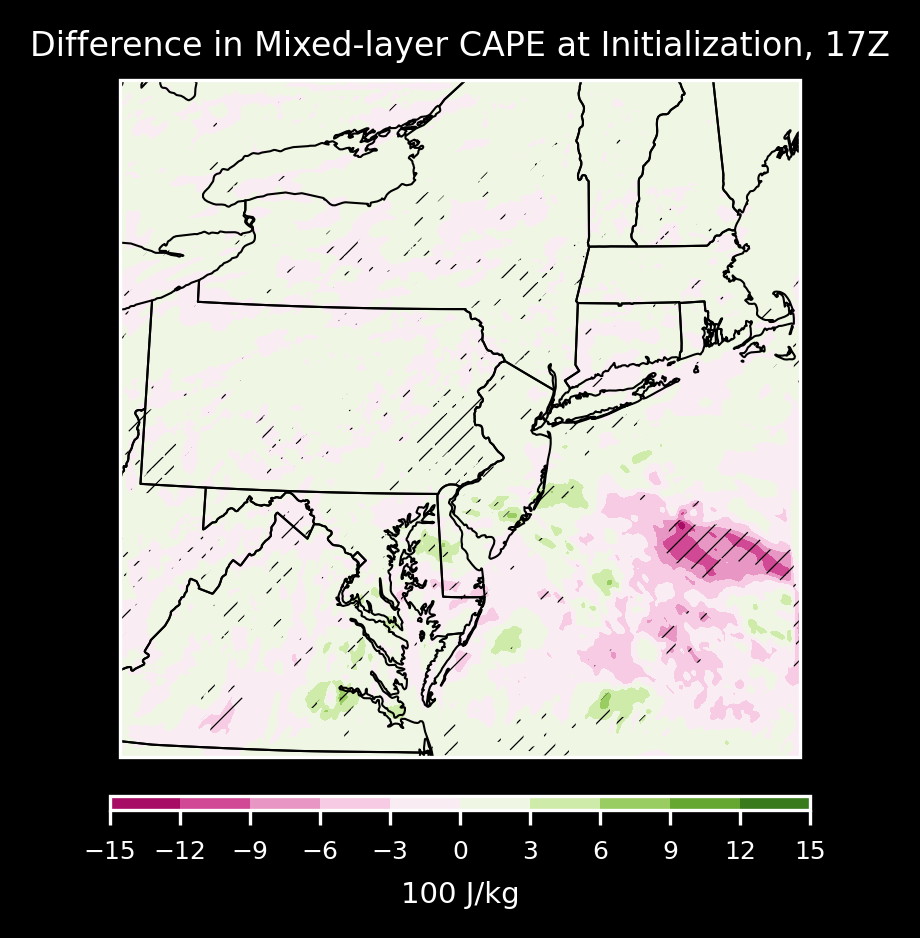

In [42]:
levels = np.arange(-1500,1501,300)/100

# Make empty figure with subplots
fig, ax = plt.subplots(
    1,
    1,
    subplot_kw=dict(projection=proj),
    dpi=300,
    layout="constrained",
    figsize=(3, 3),
)

# Plot difference
c = ax.contourf(
    lon,
    lat,
    diff.where(diff!=0,0.00001)/100,
    levels=levels,
    transform=ccrs.PlateCarree(),
    cmap="PiYG",
)

# Hatch over statistically significant areas
m = ax.contourf(
    lon,
    lat,
    mask,
    transform=ccrs.PlateCarree(),
    levels=[0, 0.5, 1],
    hatches=["", "/////"],
    colors="none",
)

# Add states
c.axes.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="black")  # type: ignore

# Add colorbar to figure
cb = fig.colorbar(
    c,
    ax=ax,
    shrink=0.8,
    aspect=50,
    orientation="horizontal",
)
cb.ax.tick_params(labelsize=6)
cb.set_label("100 J/kg", fontsize=7)
cb.set_ticks(levels) # type: ignore 

# Add title
plt.title("Difference in Mixed-layer CAPE at Initialization, 17Z", fontsize=8)

plt.show()


## Synoptic

### 500, 700, 850

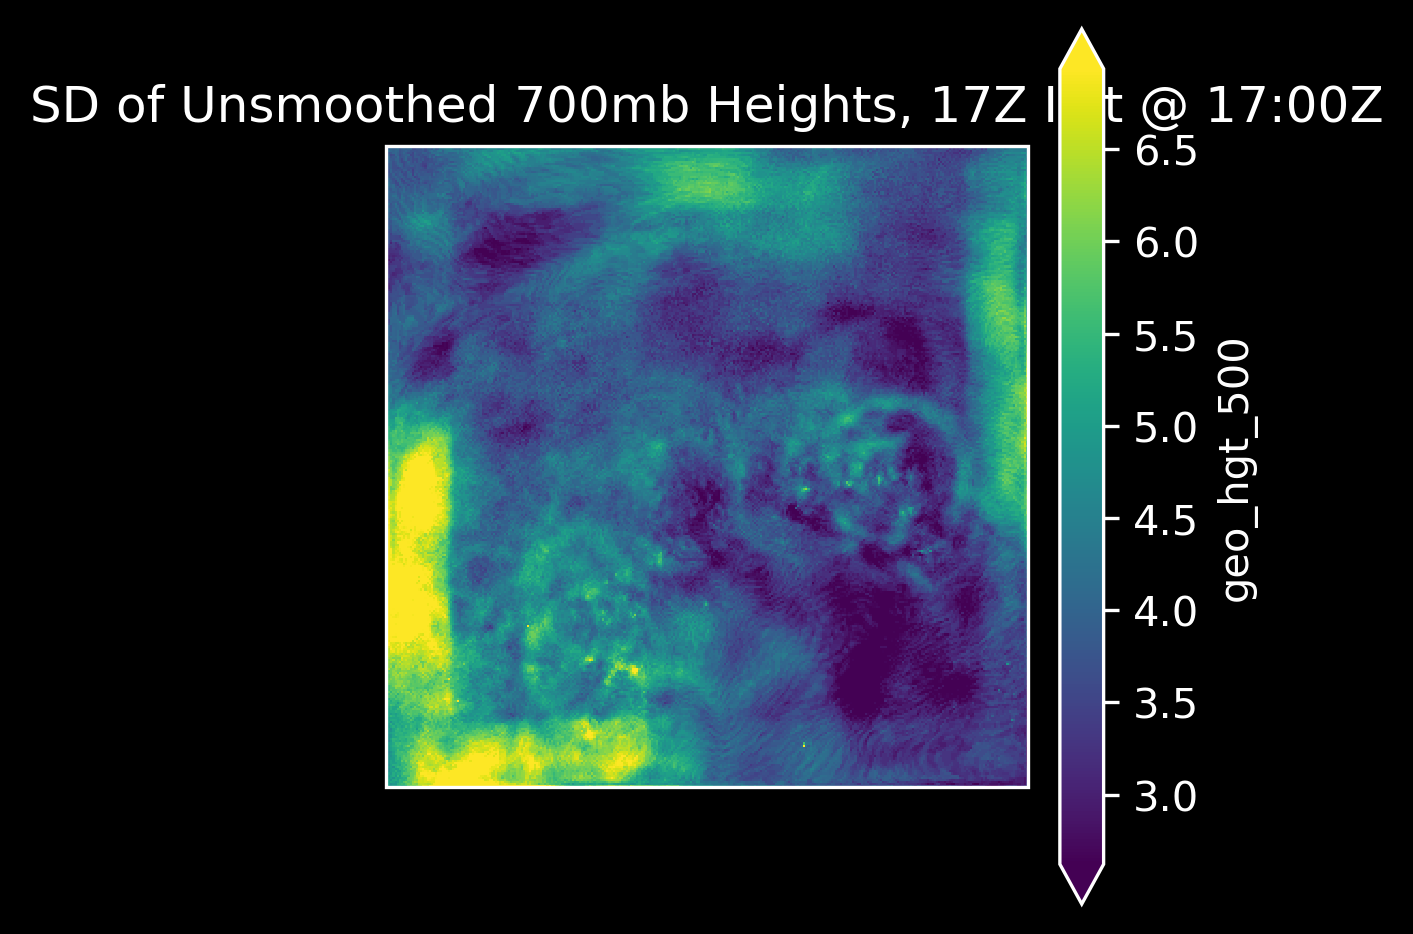

In [60]:
# Make empty figure with subplots
fig, ax = plt.subplots(
    1,
    1,
    subplot_kw=dict(projection=proj),
    dpi=300,
    layout="constrained",
    figsize=(3, 3),
)

p = wofs.geo_hgt_500.isel(time=1).std(dim="ne").plot(robust=True,ax=ax)
# Add states
p.axes.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="black")  # type: ignore

plt.title("SD of Unsmoothed 700mb Heights, 17Z Init @ 17:00Z")
# plt.tight_layout()
plt.show()

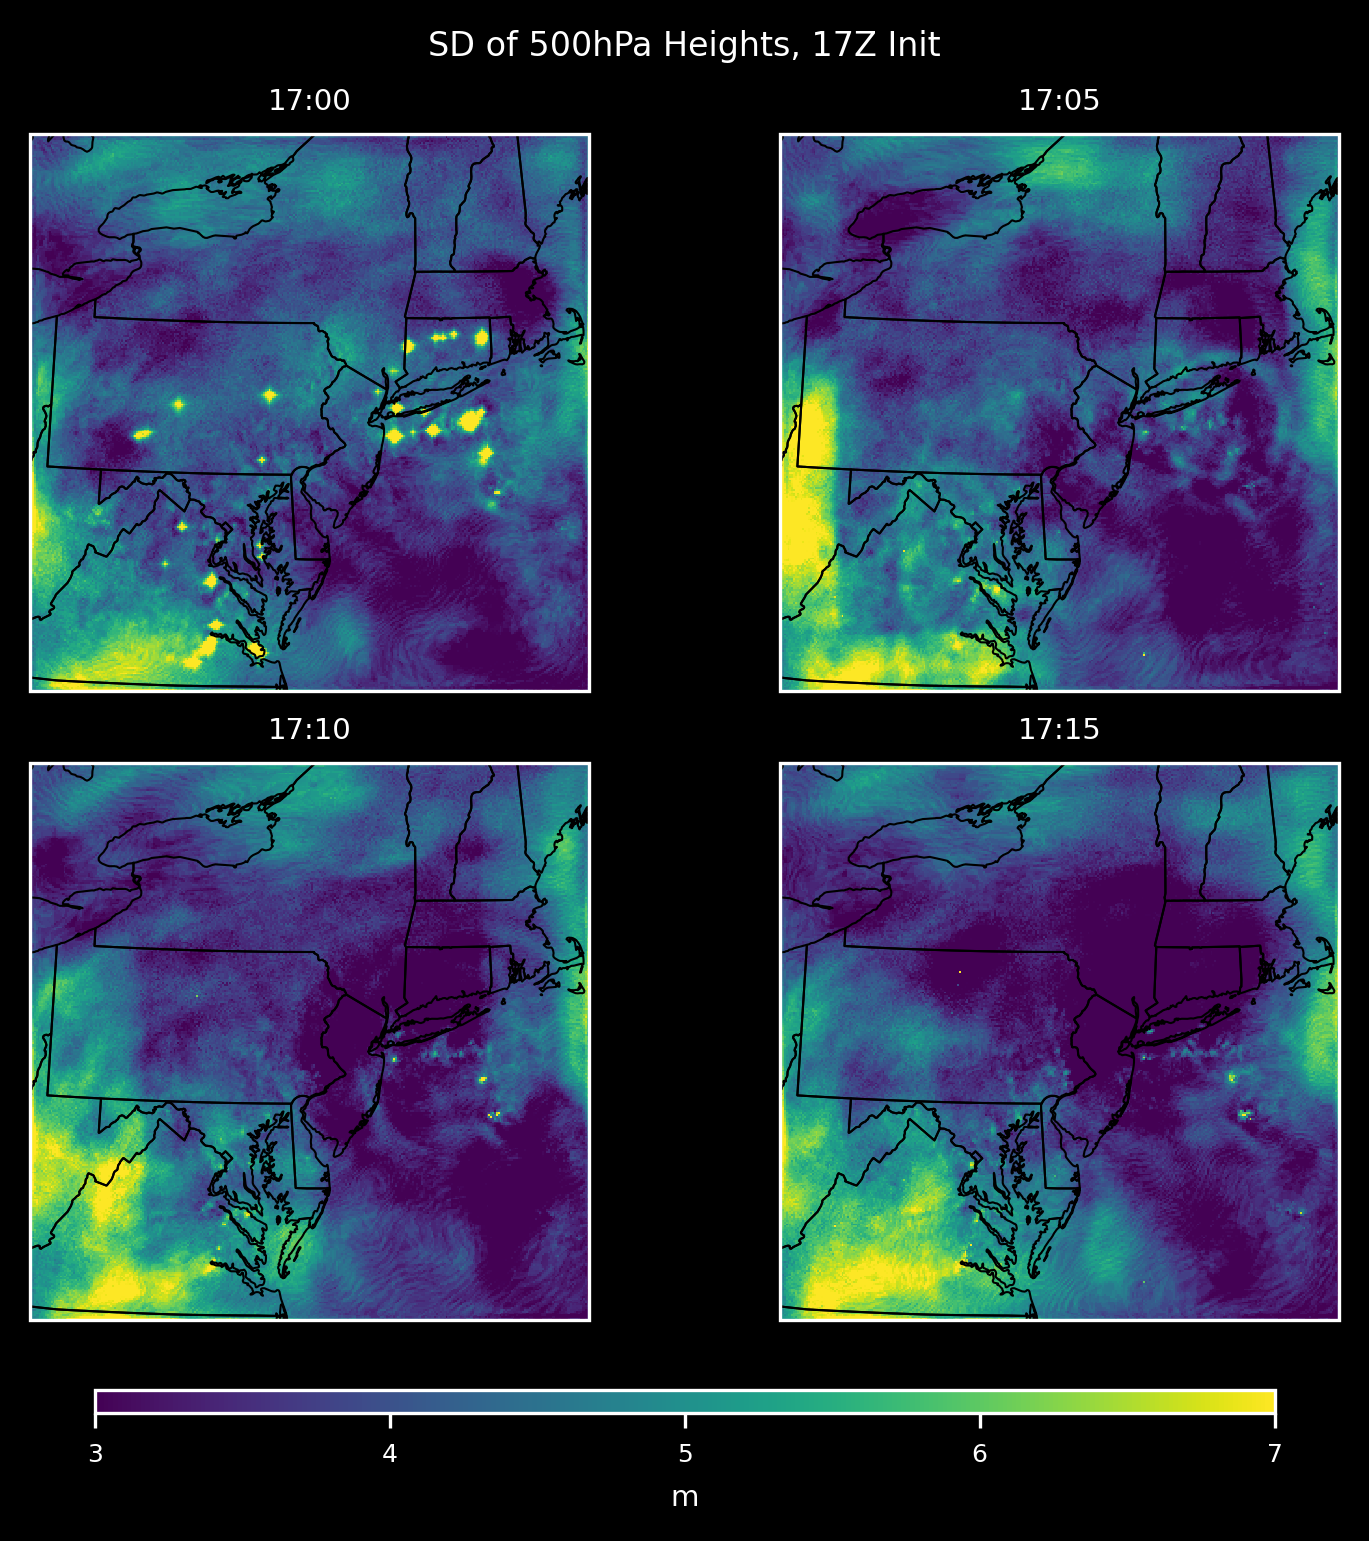

In [83]:
levels = range(3,8,1)
times = range(0,4,1)
titles = ["17:00","17:05","17:10","17:15"]

# Make empty figure with subplots
fig, axes = plt.subplots(
    2,
    2,
    subplot_kw=dict(projection=proj),
    dpi=300,
    layout="constrained",
    figsize=(5, 5),
)

for i,ax in enumerate(axes.flat):
    # Plot difference
    p = ax.pcolormesh(
        lon,
        lat,
        wofs.geo_hgt_500.isel(time=times[i]).std(dim="ne"),
        vmax=7,
        vmin=3,
        transform=ccrs.PlateCarree(),
        cmap="viridis",
    )

    # Add states
    p.axes.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="black")  # type: ignore

    ax.set_title(titles[i],fontsize=7)

# Add colorbar to figure
cb = fig.colorbar(
    p,
    ax=axes,
    shrink=0.8,
    aspect=50,
    orientation="horizontal",
)
cb.ax.tick_params(labelsize=6)
cb.set_label("m", fontsize=7)
cb.set_ticks(levels) # type: ignore 

# Add title
plt.suptitle("SD of 500hPa Heights, 17Z Init", fontsize=8)

plt.show()


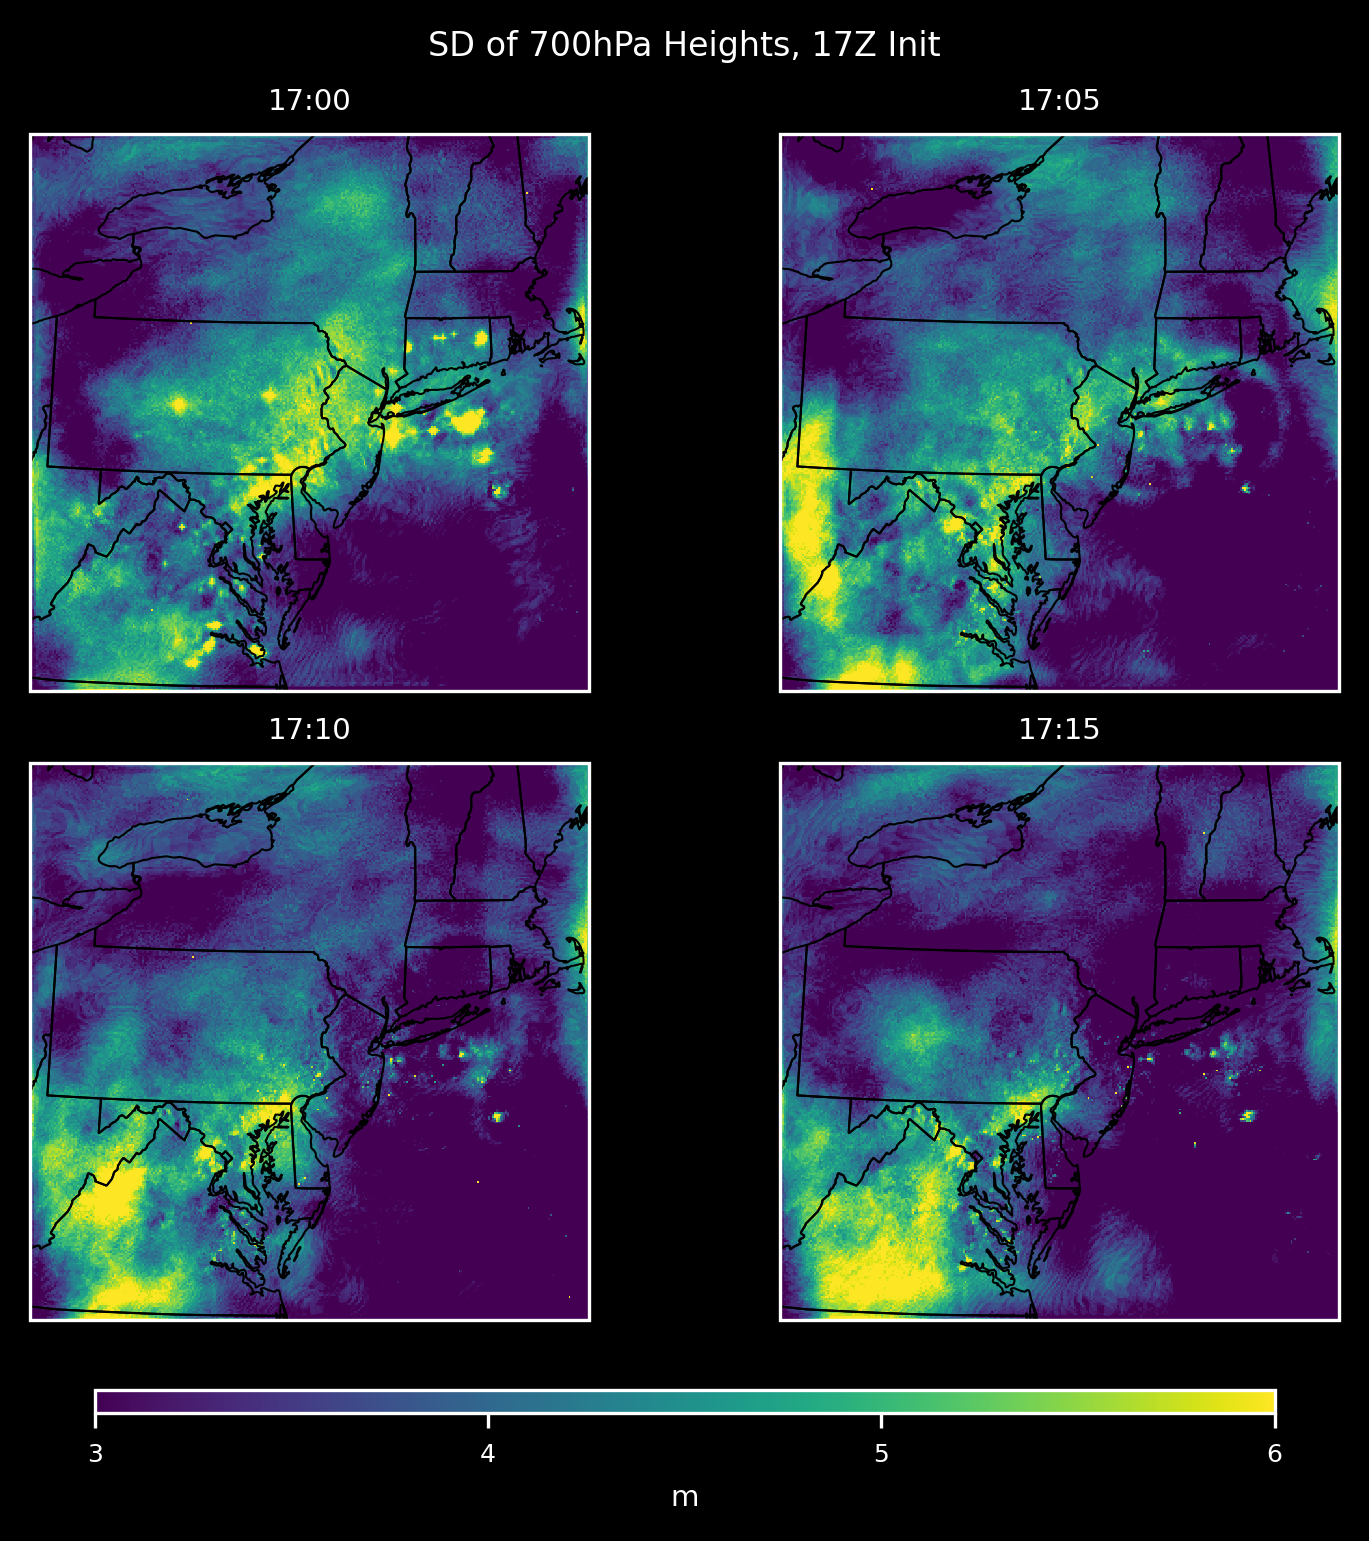

In [88]:
levels = range(3,7,1)
times = range(0,4,1)
titles = ["17:00","17:05","17:10","17:15"]

# Make empty figure with subplots
fig, axes = plt.subplots(
    2,
    2,
    subplot_kw=dict(projection=proj),
    dpi=300,
    layout="constrained",
    figsize=(5, 5),
)

for i,ax in enumerate(axes.flat):
    # Plot difference
    p = ax.pcolormesh(
        lon,
        lat,
        wofs.geo_hgt_700.isel(time=times[i]).std(dim="ne"),
        vmax=6,
        vmin=3,
        transform=ccrs.PlateCarree(),
        cmap="viridis",
    )

    # Add states
    p.axes.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="black")  # type: ignore

    ax.set_title(titles[i],fontsize=7)

# Add colorbar to figure
cb = fig.colorbar(
    p,
    ax=axes,
    shrink=0.8,
    aspect=50,
    orientation="horizontal",
)
cb.ax.tick_params(labelsize=6)
cb.set_label("m", fontsize=7)
cb.set_ticks(levels) # type: ignore 

# Add title
plt.suptitle("SD of 700hPa Heights, 17Z Init", fontsize=8)

plt.show()


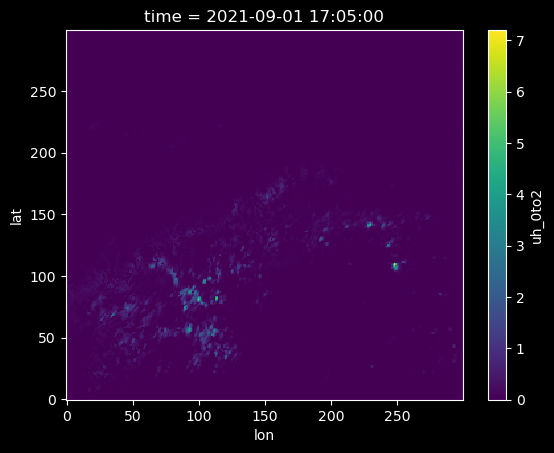

In [13]:
wofs.uh_0to2.isel(time=1).std(dim="ne").plot()

In [68]:
# Function to handle chunking, resampling, and returning both mask and diff
def process_geo_heights(level, wet_ne, dry_ne):
    geo_hgt = mpcalc.smooth_gaussian(
        getattr(wofs, f"geo_hgt_{level}").isel(time=0), n=12
    )
    geo_hgt_wet = xr.concat([geo_hgt.isel(ne=n) for n in wet_ne], dim="ne")
    geo_hgt_dry = xr.concat([geo_hgt.isel(ne=n) for n in dry_ne], dim="ne")

    geo_hgt_chunked = geo_hgt.squeeze().chunk({"lat": 25, "lon": 25})

    set1 = resample_iterations_idx(
        geo_hgt_chunked, 1000, dim="ne", replace=False, dim_max=4
    ).mean(dim="ne")

    set2 = resample_iterations_idx(
        geo_hgt_chunked, 1000, dim="ne", replace=False, dim_max=4
    ).mean(dim="ne")

    with ProgressBar():
        result = (set1 - set2).quantile([0.05, 0.95], dim="iteration").compute()

    diff = (geo_hgt_wet.mean(dim="ne") - geo_hgt_dry.mean(dim="ne")).compute()

    mask = (diff < result.sel(quantile=0.05).squeeze()) | (
        diff > result.sel(quantile=0.95).squeeze()
    )

    return mask, diff


# Loop through 500, 700, and 850 levels, returning both mask and diff
levels = [500, 700, 850]
results = {}
for level in levels:
    mask, diff = process_geo_heights(level, wet_ne, dry_ne)
    results[level] = {"mask": mask, "diff": diff}


[########################################] | 100% Completed | 46.15 ss
[########################################] | 100% Completed | 46.58 ss
[########################################] | 100% Completed | 46.88 ss


In [ ]:
levels = np.arange(-1500,1501,300)/100

# Make empty figure with subplots
fig, ax = plt.subplots(
    1,
    1,
    subplot_kw=dict(projection=proj),
    dpi=300,
    layout="constrained",
    figsize=(3, 3),
)

# Plot difference
c = ax.contourf(
    lon,
    lat,
    diff.where(diff!=0,0.00001)/100,
    levels=levels,
    transform=ccrs.PlateCarree(),
    cmap="PiYG",
)

# Hatch over statistically significant areas
m = ax.contourf(
    lon,
    lat,
    mask,
    transform=ccrs.PlateCarree(),
    levels=[0, 0.5, 1],
    hatches=["", "/////"],
    colors="none",
)

# Add states
c.axes.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="black")  # type: ignore

# Add colorbar to figure
cb = fig.colorbar(
    c,
    ax=ax,
    shrink=0.8,
    aspect=50,
    orientation="horizontal",
)
cb.ax.tick_params(labelsize=6)
cb.set_label("100 J/kg", fontsize=7)
cb.set_ticks(levels) # type: ignore 

# Add title
plt.title("Difference in Mixed-layer CAPE at Initialization, 17Z", fontsize=8)

plt.show()


In [57]:
# Grab geo_hgt_700 at initialization time
geo_hgt_700 = wofs.geo_hgt_700.isel(time=0)
geo_hgt_700_wet = xr.concat([geo_hgt_700.isel(ne=n) for n in wet_ne], dim="ne")
geo_hgt_700_dry = xr.concat([geo_hgt_700.isel(ne=n) for n in dry_ne], dim="ne")

# Chunk lat and lon of geo_hgt_700
geo_hgt_700_chunked = geo_hgt_700.squeeze().chunk({"lat": 25, "lon": 25})

# Resample and compute means
set1 = resample_iterations_idx(
    geo_hgt_700_chunked,
    1000,
    dim="ne",
    replace=False,
    dim_max=4,
).mean(dim="ne")

set2 = resample_iterations_idx(
    geo_hgt_700_chunked,
    1000,
    dim="ne",
    replace=False,
    dim_max=4,
).mean(dim="ne")

# Compute the difference and quantiles
with ProgressBar():
    result = (set1 - set2).quantile([0.05, 0.95], dim="iteration").compute()

# Get difference between wet and dry ensemble members
diff = (geo_hgt_700_wet.mean(dim="ne") - geo_hgt_700_dry.mean(dim="ne")).compute()

mask = (diff < result.sel(quantile=0.05).squeeze()) | (  # type: ignore
    diff > result.sel(quantile=0.95).squeeze()  # type: ignore
)


[##                                      ] | 6% Completed | 111.77 ms

[########################################] | 100% Completed | 46.08 ss


In [89]:
foo = get_wofs_all(18)

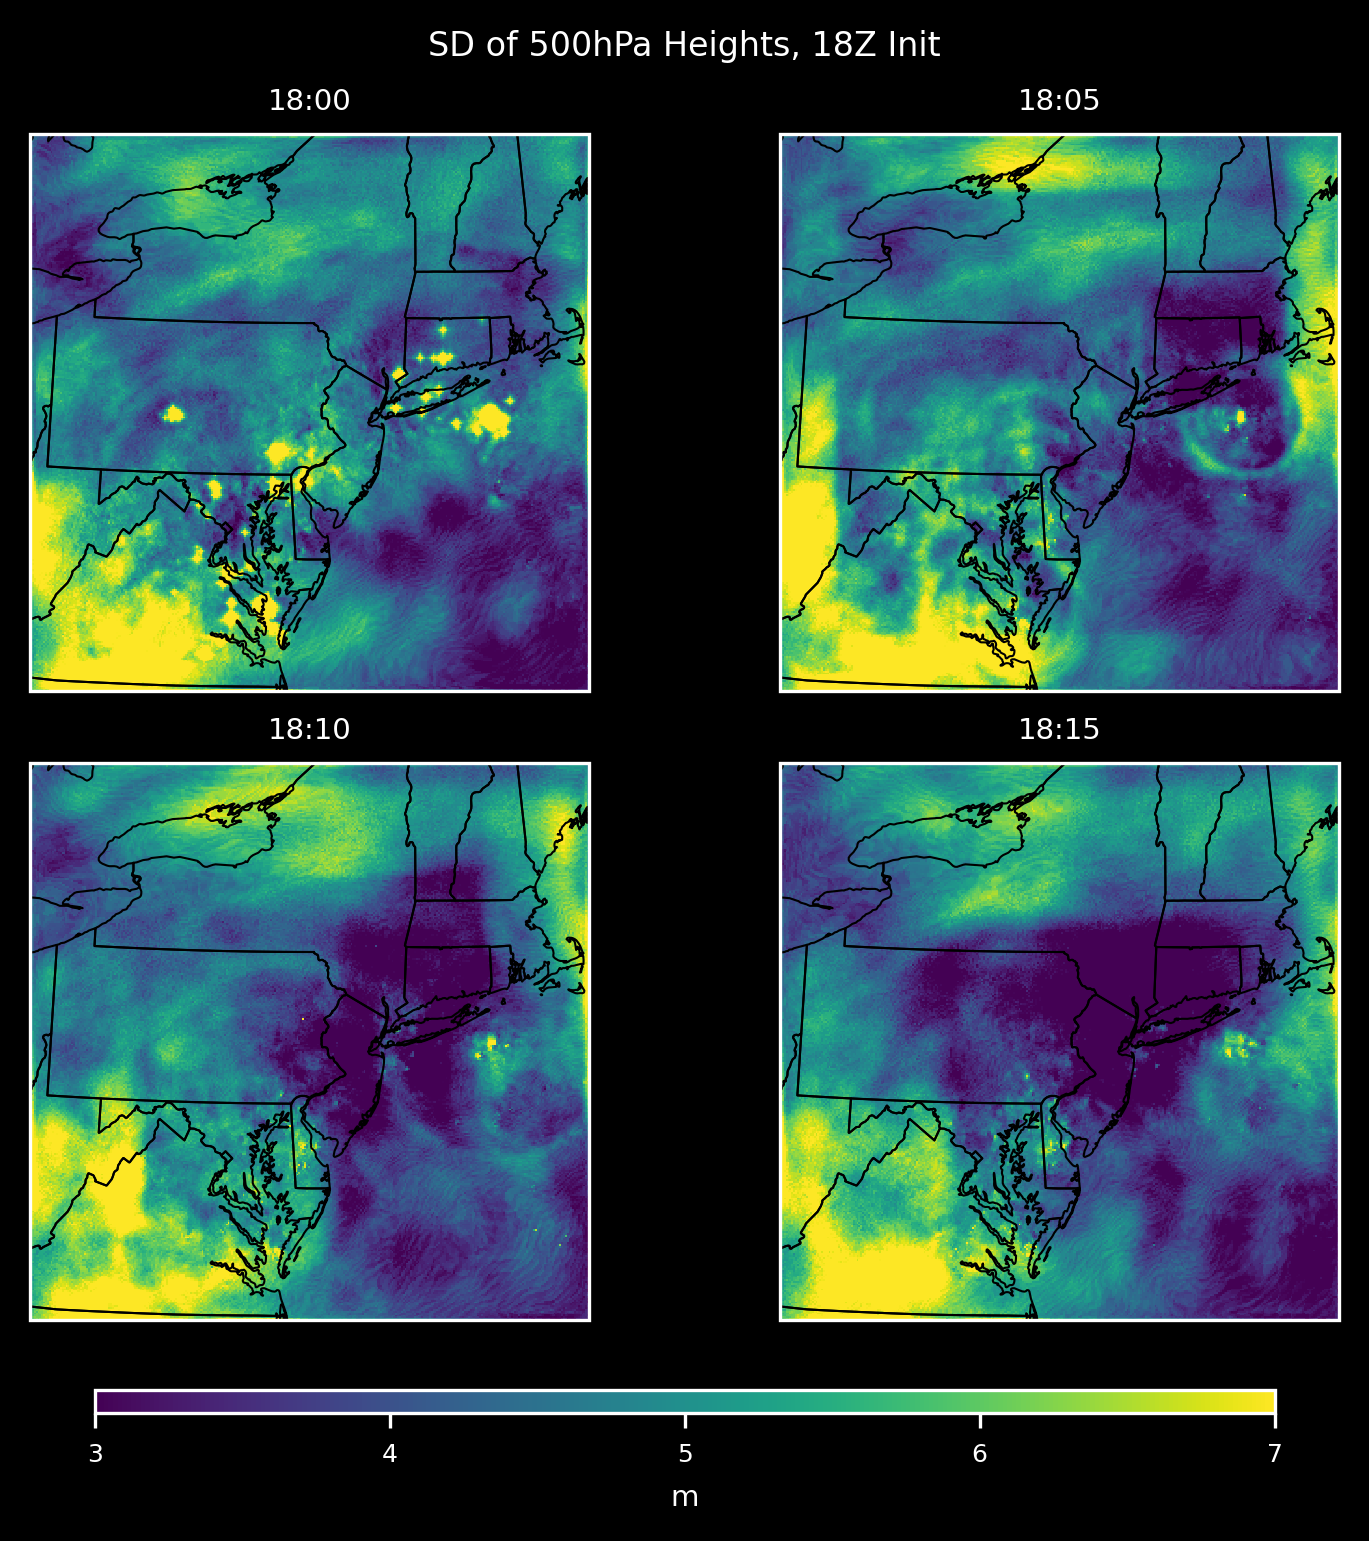

In [90]:
levels = range(3,8,1)
times = range(0,4,1)
titles = ["18:00","18:05","18:10","18:15"]

# Make empty figure with subplots
fig, axes = plt.subplots(
    2,
    2,
    subplot_kw=dict(projection=proj),
    dpi=300,
    layout="constrained",
    figsize=(5, 5),
)

for i,ax in enumerate(axes.flat):
    # Plot difference
    p = ax.pcolormesh(
        lon,
        lat,
        foo.geo_hgt_500.isel(time=times[i]).std(dim="ne"),
        vmax=7,
        vmin=3,
        transform=ccrs.PlateCarree(),
        cmap="viridis",
    )

    # Add states
    p.axes.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="black")  # type: ignore

    ax.set_title(titles[i],fontsize=7)

# Add colorbar to figure
cb = fig.colorbar(
    p,
    ax=axes,
    shrink=0.8,
    aspect=50,
    orientation="horizontal",
)
cb.ax.tick_params(labelsize=6)
cb.set_label("m", fontsize=7)
cb.set_ticks(levels) # type: ignore 

# Add title
plt.suptitle("SD of 500hPa Heights, 18Z Init", fontsize=8)

plt.show()


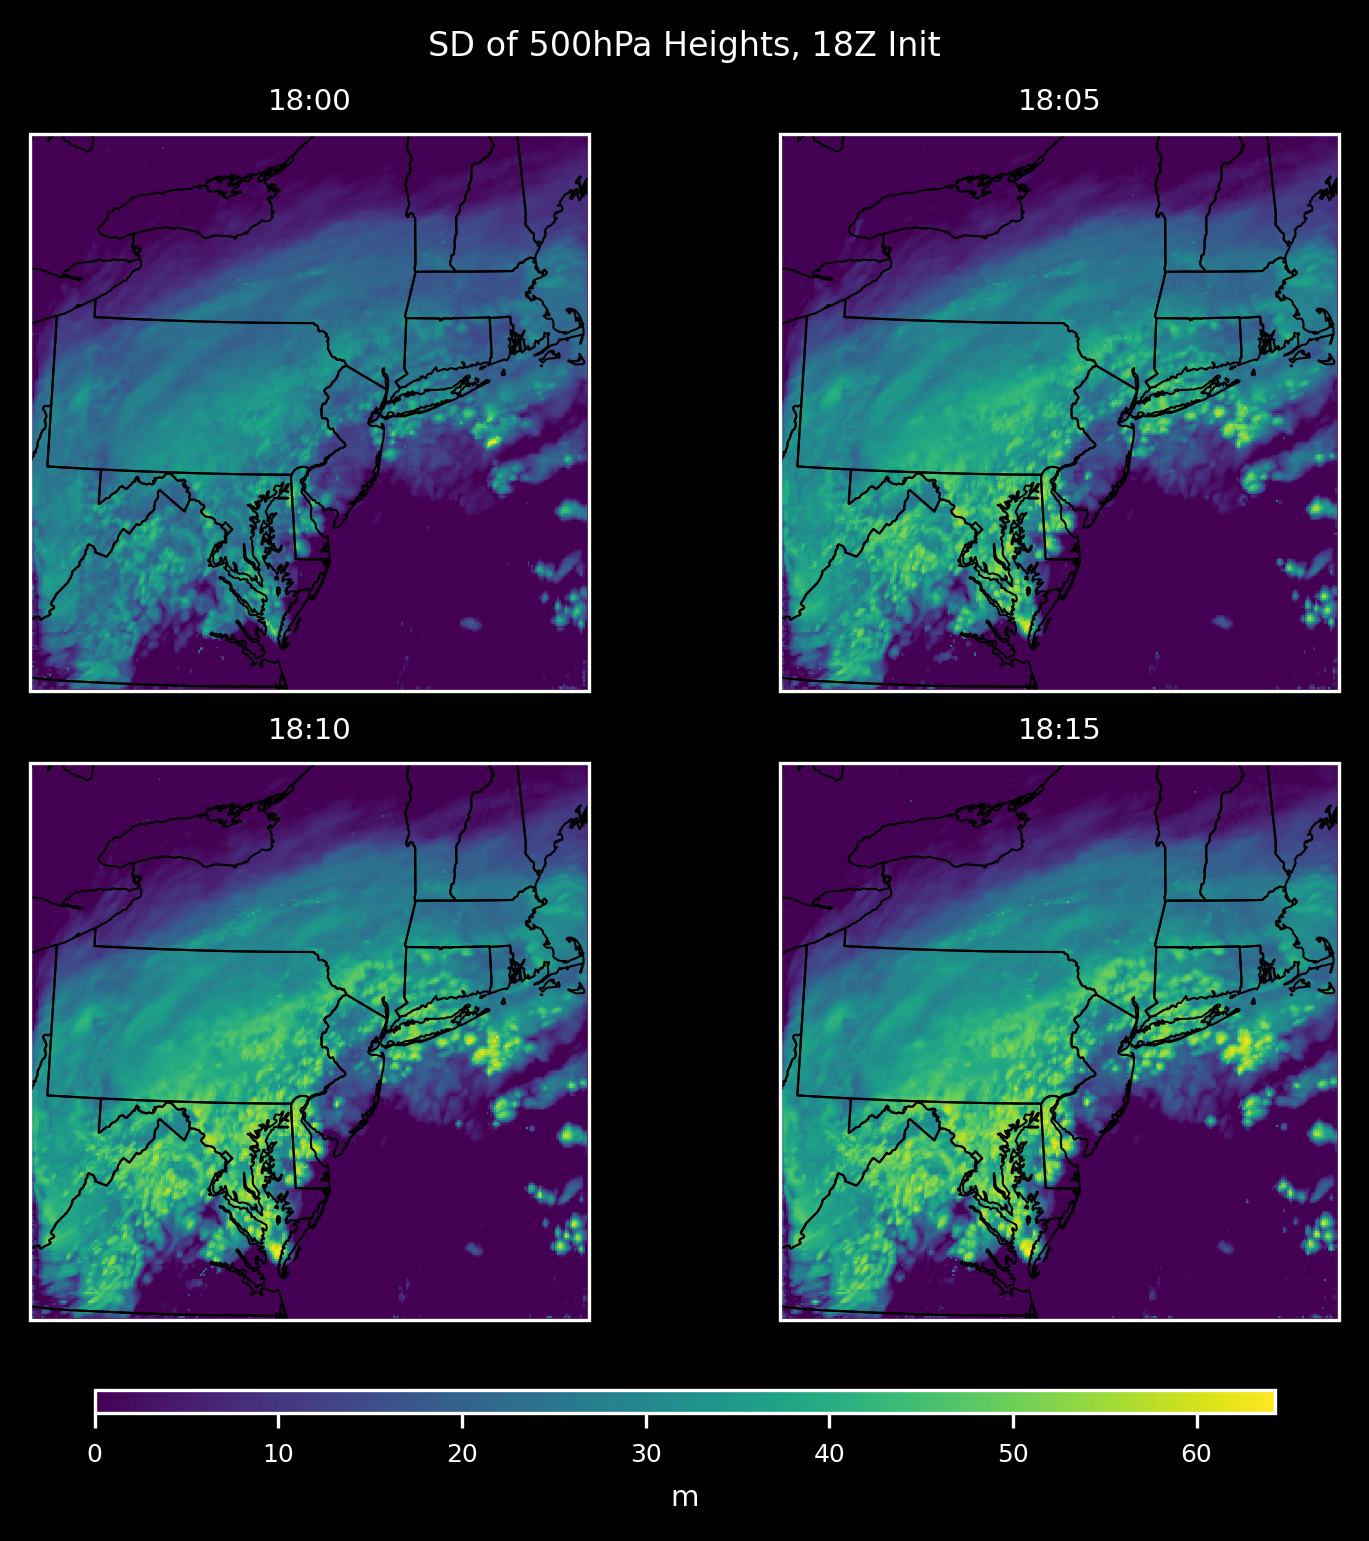

In [94]:
levels = range(3,8,1)
times = range(0,4,1)
titles = ["18:00","18:05","18:10","18:15"]

# Make empty figure with subplots
fig, axes = plt.subplots(
    2,
    2,
    subplot_kw=dict(projection=proj),
    dpi=300,
    layout="constrained",
    figsize=(5, 5),
)

for i,ax in enumerate(axes.flat):
    # Plot difference
    p = ax.pcolormesh(
        lon,
        lat,
        foo.comp_dz.isel(time=times[i]).max(dim="ne"),
        transform=ccrs.PlateCarree(),
        cmap="viridis",
    )

    # Add states
    p.axes.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="black")  # type: ignore

    ax.set_title(titles[i],fontsize=7)

# Add colorbar to figure
cb = fig.colorbar(
    p,
    ax=axes,
    shrink=0.8,
    aspect=50,
    orientation="horizontal",
)
cb.ax.tick_params(labelsize=6)
cb.set_label("m", fontsize=7)
# cb.set_ticks(levels) # type: ignore 

# Add title
plt.suptitle("SD of 500hPa Heights, 18Z Init", fontsize=8)

plt.show()
